In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import timesfm
import matplotlib.dates as mdates
%matplotlib inline

folder_path = os.path.join(os.getcwd(), 'fastStorage/2013-8/')

2024-06-30 11:21:21.392454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
def df_processing(df):

    df.columns = df.columns.str.replace('\t', '')
    df.insert(0, "DateTime", df['Timestamp [ms]'].apply(lambda x: datetime.datetime.fromtimestamp(x).replace(second=0, microsecond=0)))
    df = df.drop(columns=['Timestamp [ms]'])
    df.set_index('DateTime', inplace=True)
    df = df.sort_index()
    df = df.resample('5min').ffill()
    df = df[['CPU cores', 'CPU usage [%]']]
    return df

df2 = pd.read_csv(os.path.join(folder_path, '983.csv'), sep=';')
df4 = pd.read_csv(os.path.join(folder_path, '980.csv'), sep=';')
df6 = pd.read_csv(os.path.join(folder_path, '943.csv'), sep=';')

dfs_list = [df2, df4, df6]
dfs = [df_processing(df) for df in dfs_list]
df2 = dfs[0]
df4 = dfs[1]
df6 = dfs[2]

merged_df = pd.concat(dfs)
# # Sort the final merged DataFrame by the index
merged_df = merged_df.sort_index()
df = merged_df
#df = df[['CPU cores', 'CPU usage [%]']]
df.reset_index(inplace=True)
df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "target"}, inplace=True)
df.head(12)

,ds,unique_id,target
0,2013-08-12 14:40:00,2,24.666667
1,2013-08-12 14:40:00,6,37.455556
2,2013-08-12 14:40:00,4,46.500000
3,2013-08-12 14:45:00,2,27.033333
4,2013-08-12 14:45:00,6,38.388889
5,2013-08-12 14:45:00,4,38.516667
6,2013-08-12 14:50:00,2,27.633333
7,2013-08-12 14:50:00,6,38.966667
8,2013-08-12 14:50:00,4,44.866667
9,2013-08-12 14:55:00,2,25.366667


In [4]:
def time_reindex(df, start_datetime, end_datetime, core):

    intervals_per_day = 288
    one_day_range = pd.date_range(start=start_datetime, periods=intervals_per_day, freq='5min')
    unique_example_ids = df['example_id'].unique()
    new_timestamps = pd.date_range(start=start_datetime, end=end_datetime, freq='5min')

    # Ensure the length matches the number of rows per example_id
    if len(new_timestamps) < intervals_per_day * len(unique_example_ids):
        raise ValueError("Not enough timestamps to cover all rows")

    # Create a new column for updated DateTime
    df['UpdatedDateTime'] = pd.NaT

    # Update the DateTime for each example_id
    for idx, example_id in enumerate(unique_example_ids):
        start_idx = idx * intervals_per_day
        end_idx = start_idx + intervals_per_day
        df.loc[df['example_id'] == example_id, 'UpdatedDateTime'] = new_timestamps[start_idx:end_idx].values

    df.drop(columns=['DateTime'], inplace=True)
    df['DateTime'] = df['UpdatedDateTime']
    df.set_index('DateTime', inplace=True)
    df.sort_index()

    df.drop(columns=['example_id', 'UpdatedDateTime'], inplace=True)
    df.insert(0, 'CPU cores', core)
    df.reset_index(inplace=True)

    return df        

df2_synth = pd.read_csv('synthetic_data/twocore_synth_v2.csv')
df2_synth = df2_synth[df2_synth['example_id'] < 5]
df4_synth = pd.read_csv('synthetic_data/fourcore_synth_v2.csv')
df4_synth = df4_synth[df4_synth['example_id'] < 5]
df6_synth = pd.read_csv('synthetic_data/sixcore_synth_v2.csv')
df6_synth = df6_synth[df6_synth['example_id'] < 5]
start_datetime = pd.Timestamp('2013-09-11 14:40:00')
end_datetime = pd.Timestamp('2013-09-16 14:35:00')
df2_synth = time_reindex(df2_synth, start_datetime, end_datetime, core=2)
df4_synth = time_reindex(df4_synth, start_datetime, end_datetime, core=4)
df6_synth = time_reindex(df6_synth, start_datetime, end_datetime, core=6)

merged_synth = pd.concat([df2_synth, df4_synth, df6_synth])
merged_synth.reset_index(inplace=True)
merged_synth = merged_synth.sort_values(by=['DateTime', 'CPU cores'])
merged_synth = merged_synth[['DateTime', 'CPU cores', 'CPU usage [%]']]
merged_synth.set_index('DateTime', inplace=True)
merged_synth.reset_index(inplace=True)
merged_synth.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "target"}, inplace=True)
df_synth = merged_synth
df_synth.head(10)

,ds,unique_id,target
0,2013-09-11 14:40:00,2,41.130199
1,2013-09-11 14:40:00,4,43.931690
2,2013-09-11 14:40:00,6,36.204689
3,2013-09-11 14:45:00,2,47.011131
4,2013-09-11 14:45:00,4,45.053787
5,2013-09-11 14:45:00,6,33.252552
6,2013-09-11 14:50:00,2,44.178123
7,2013-09-11 14:50:00,4,43.836456
8,2013-09-11 14:50:00,6,38.030170
9,2013-09-11 14:55:00,2,49.651947


In [4]:
df.tail()

,ds,unique_id,target
25915,2013-09-11 14:30:00,2,67.666667
25916,2013-09-11 14:30:00,4,40.433333
25917,2013-09-11 14:35:00,4,46.550000
25918,2013-09-11 14:35:00,2,58.933333
25919,2013-09-11 14:35:00,6,39.988095


In [5]:
df_synth.tail()

,ds,unique_id,target
4315,2013-09-16 14:30:00,4,40.380344
4316,2013-09-16 14:30:00,6,33.556293
4317,2013-09-16 14:35:00,2,27.481838
4318,2013-09-16 14:35:00,4,47.144196
4319,2013-09-16 14:35:00,6,36.964466


In [6]:
df = pd.concat([df, df_synth])
df.set_index('ds', inplace=True)
df.reset_index(inplace=True)
df.tail(10)

,ds,unique_id,target
30230,2013-09-16 14:20:00,6,39.906494
30231,2013-09-16 14:25:00,2,30.519901
30232,2013-09-16 14:25:00,4,38.597198
30233,2013-09-16 14:25:00,6,35.212704
30234,2013-09-16 14:30:00,2,31.127245
30235,2013-09-16 14:30:00,4,40.380344
30236,2013-09-16 14:30:00,6,33.556293
30237,2013-09-16 14:35:00,2,27.481838
30238,2013-09-16 14:35:00,4,47.144196
30239,2013-09-16 14:35:00,6,36.964466


In [7]:
horizon_len = 6
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
# df_train = df[:23328]
# df_test = df[23328:]
df_train.shape, df_test.shape


((24192, 3), (6048, 3))

In [8]:
tfm = timesfm.TimesFm(
    context_len=288,
    horizon_len=6,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 1.95 seconds.
Restoring checkpoint from /home/babarali/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.85 seconds.
Jitting decoding.
Jitted decoding in 13.78 seconds.


In [9]:
def timesfm_pred(pred_length, df_train, df_test):
    all_preds = []
    iter = int(df_test.shape[0]/(pred_length*3))
    inf_time = []

    for i in range(iter):

        s_time = time.time()
        predictions = tfm.forecast_on_df(
        inputs=df_train,
        freq='5min',  # monthly
        value_name="target"
        )
        inf = time.time() - s_time
        inf_time.append(inf)

        all_preds.append(predictions)
        test_values = df_test.loc[df_test['ds'].isin(predictions['ds'])].reset_index(drop=True)
        # Add the corresponding test values for the next iteration
        df_train = pd.concat([df_train, test_values]).reset_index(drop=True)

    all_preds = pd.concat(all_preds).reset_index()

    return all_preds, inf_time


timefm_preds, inf_time = timesfm_pred(6, df_train, df_test)

Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe

In [10]:
df_test.shape

(6048, 3)

In [11]:
inf_time

[0.615100622177124,
 0.5281600952148438,
 0.5221412181854248,
 0.5291275978088379,
 0.5472328662872314,
 0.5845904350280762,
 0.5542514324188232,
 0.5577971935272217,
 0.575476884841919,
 0.5792922973632812,
 0.5889925956726074,
 0.5916647911071777,
 0.5940370559692383,
 0.6067631244659424,
 0.6018455028533936,
 0.6343019008636475,
 0.6110630035400391,
 0.6213498115539551,
 0.6284618377685547,
 0.6459033489227295,
 0.6264495849609375,
 0.6281609535217285,
 0.6327414512634277,
 0.6238760948181152,
 0.623075008392334,
 0.628084659576416,
 0.6270523071289062,
 0.6275177001953125,
 0.6411752700805664,
 0.6557106971740723,
 0.6832256317138672,
 0.6616349220275879,
 0.6631159782409668,
 0.6454076766967773,
 0.6511936187744141,
 0.6491150856018066,
 0.6493411064147949,
 0.6660287380218506,
 0.6548264026641846,
 0.6542856693267822,
 0.6822865009307861,
 0.6730737686157227,
 0.662623405456543,
 0.654437780380249,
 0.6682140827178955,
 0.6620051860809326,
 0.6582009792327881,
 0.6655464172363281

In [12]:
timefm_preds = timefm_preds.sort_values(by=['ds', 'unique_id'])
timefm_preds.set_index('ds', inplace=True)
timefm_preds.reset_index(inplace=True)
timefm_preds.drop(columns=['index'], inplace=True)
timefm_preds

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,2013-09-09 14:40:00,2,56.758137,52.317928,54.328609,55.139233,55.983719,56.758137,57.661255,58.395153,59.413689,61.004345
1,2013-09-09 14:40:00,4,43.508926,41.150173,42.264099,42.810921,43.220299,43.508926,43.868370,44.287224,44.799374,45.493999
2,2013-09-09 14:40:00,6,38.187359,35.331100,36.358524,37.195465,37.644447,38.187359,38.457706,38.994781,39.689499,40.509941
3,2013-09-09 14:45:00,2,56.955750,51.958611,53.900345,55.153652,56.134205,56.955750,57.850170,58.866821,59.994411,61.808762
4,2013-09-09 14:45:00,4,48.362938,45.435696,46.742496,47.364319,47.919514,48.362938,48.741852,49.281132,49.804893,50.661110
...,...,...,...,...,...,...,...,...,...,...,...,...
6043,2013-09-16 14:30:00,4,41.788792,38.803246,39.791702,40.541031,41.172596,41.788792,42.519783,43.234318,44.189041,45.787453
6044,2013-09-16 14:30:00,6,38.884056,33.553795,35.332653,36.728455,37.824596,38.884056,39.982704,41.097588,42.415005,44.322517
6045,2013-09-16 14:35:00,2,30.494267,27.326321,28.141798,29.157602,29.913225,30.494267,31.355511,32.125069,33.481136,35.396492
6046,2013-09-16 14:35:00,4,41.691154,38.802364,39.713158,40.410961,41.042999,41.691154,42.360512,43.160694,44.107422,45.651730


In [13]:
df_test.head(10)

,ds,unique_id,target
24192,2013-09-09 14:40:00,2,58.833333
24193,2013-09-09 14:40:00,4,43.833333
24194,2013-09-09 14:40:00,6,40.722222
24195,2013-09-09 14:45:00,4,46.816667
24196,2013-09-09 14:45:00,6,40.333333
24197,2013-09-09 14:45:00,2,54.033333
24198,2013-09-09 14:50:00,2,56.400000
24199,2013-09-09 14:50:00,6,43.477778
24200,2013-09-09 14:50:00,4,43.733333
24201,2013-09-09 14:55:00,6,42.800000


In [14]:
timefm_preds_copy = timefm_preds

In [15]:
df_test = df_test.sort_values(by=['ds', 'unique_id'])
df_test.set_index('ds', inplace=True)
df_test.reset_index(inplace=True)
df_test.head()

,ds,unique_id,target
0,2013-09-09 14:40:00,2,58.833333
1,2013-09-09 14:40:00,4,43.833333
2,2013-09-09 14:40:00,6,40.722222
3,2013-09-09 14:45:00,2,54.033333
4,2013-09-09 14:45:00,4,46.816667


In [16]:
timefm_preds['CPU usage [%]'] = df_test['target']
timefm_preds

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%]
0,2013-09-09 14:40:00,2,56.758137,52.317928,54.328609,55.139233,55.983719,56.758137,57.661255,58.395153,59.413689,61.004345,58.833333
1,2013-09-09 14:40:00,4,43.508926,41.150173,42.264099,42.810921,43.220299,43.508926,43.868370,44.287224,44.799374,45.493999,43.833333
2,2013-09-09 14:40:00,6,38.187359,35.331100,36.358524,37.195465,37.644447,38.187359,38.457706,38.994781,39.689499,40.509941,40.722222
3,2013-09-09 14:45:00,2,56.955750,51.958611,53.900345,55.153652,56.134205,56.955750,57.850170,58.866821,59.994411,61.808762,54.033333
4,2013-09-09 14:45:00,4,48.362938,45.435696,46.742496,47.364319,47.919514,48.362938,48.741852,49.281132,49.804893,50.661110,46.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,2013-09-16 14:30:00,4,41.788792,38.803246,39.791702,40.541031,41.172596,41.788792,42.519783,43.234318,44.189041,45.787453,40.380344
6044,2013-09-16 14:30:00,6,38.884056,33.553795,35.332653,36.728455,37.824596,38.884056,39.982704,41.097588,42.415005,44.322517,33.556293
6045,2013-09-16 14:35:00,2,30.494267,27.326321,28.141798,29.157602,29.913225,30.494267,31.355511,32.125069,33.481136,35.396492,27.481838
6046,2013-09-16 14:35:00,4,41.691154,38.802364,39.713158,40.410961,41.042999,41.691154,42.360512,43.160694,44.107422,45.651730,47.144196


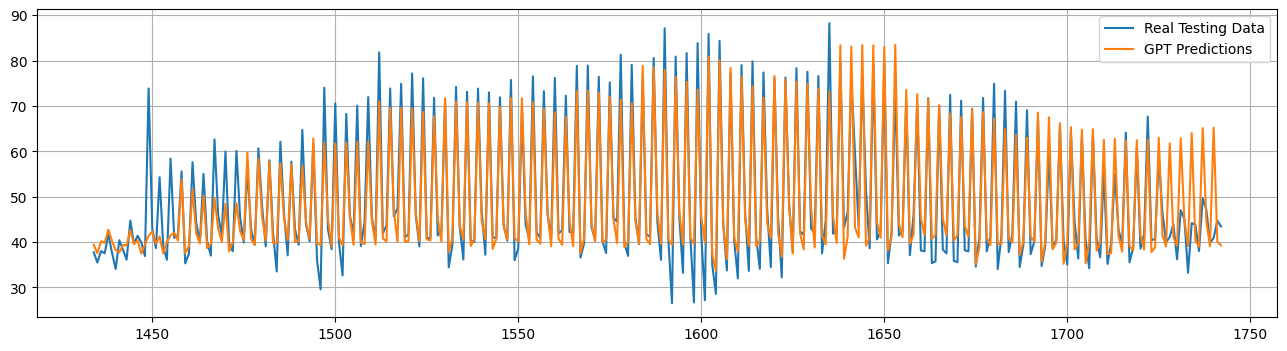

In [95]:
plt.figure(figsize=(16,4))
plt.plot(timefm_preds.index[1434:1743], timefm_preds['CPU usage [%]'][1434:1743], label='Real Testing Data')
plt.plot(timefm_preds.index[1434:1743], timefm_preds['timesfm'][1434:1743], label='GPT Predictions')
plt.grid()
plt.legend()
plt.show()

In [1]:
timefm_preds[1434:1743]

NameError: name 'timefm_preds' is not defined

In [18]:
timefm_preds_filtered = timefm_preds.iloc[840:2571]
timefm_preds_filtered.head(12)

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%]
840,2013-09-10 14:00:00,2,54.820068,48.381683,50.195778,51.907692,53.306057,54.820068,56.488472,58.316780,60.854839,65.070602,66.200000
841,2013-09-10 14:00:00,4,37.106361,33.805267,34.930965,35.725235,36.439075,37.106361,37.797363,38.466373,39.315739,40.538010,42.150000
842,2013-09-10 14:00:00,6,40.081627,37.210911,38.237358,38.890690,39.447903,40.081627,40.596943,41.301403,42.060482,43.186081,40.288889
843,2013-09-10 14:05:00,2,54.577301,47.803314,49.716557,51.461056,53.001324,54.577301,56.301453,58.196949,60.755543,65.185493,79.000000
844,2013-09-10 14:05:00,4,39.872742,36.415607,37.610111,38.457069,39.156979,39.872742,40.583977,41.320992,42.153774,43.367283,47.083333
845,2013-09-10 14:05:00,6,39.922192,36.988243,38.044144,38.770359,39.422256,39.922192,40.475658,41.195538,42.001682,43.048000,40.155556
846,2013-09-10 14:10:00,2,74.293854,62.725395,66.373947,69.033707,71.783516,74.293854,77.385590,80.841560,85.124237,93.521446,83.600000
847,2013-09-10 14:10:00,4,40.841244,38.350357,39.262032,39.924450,40.334698,40.841244,41.270271,41.787601,42.383884,43.118511,37.833333
848,2013-09-10 14:10:00,6,40.485462,37.942551,38.874599,39.525284,40.056984,40.485462,41.045380,41.605183,42.320038,43.244869,45.722222
849,2013-09-10 14:15:00,2,70.123695,59.282524,62.494278,65.066719,67.481689,70.123695,72.902786,76.056976,80.950874,89.662659,78.966667


In [19]:
timefm_preds_filtered.head()

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%]
840,2013-09-10 14:00:00,2,54.820068,48.381683,50.195778,51.907692,53.306057,54.820068,56.488472,58.316780,60.854839,65.070602,66.200000
841,2013-09-10 14:00:00,4,37.106361,33.805267,34.930965,35.725235,36.439075,37.106361,37.797363,38.466373,39.315739,40.538010,42.150000
842,2013-09-10 14:00:00,6,40.081627,37.210911,38.237358,38.890690,39.447903,40.081627,40.596943,41.301403,42.060482,43.186081,40.288889
843,2013-09-10 14:05:00,2,54.577301,47.803314,49.716557,51.461056,53.001324,54.577301,56.301453,58.196949,60.755543,65.185493,79.000000
844,2013-09-10 14:05:00,4,39.872742,36.415607,37.610111,38.457069,39.156979,39.872742,40.583977,41.320992,42.153774,43.367283,47.083333


In [20]:
timefm_preds_filtered.tail()

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%]
2566,2013-09-12 13:55:00,4,41.433643,38.407131,39.449951,40.160408,40.797726,41.433643,41.997421,42.606697,43.336441,44.485180,38.808067
2567,2013-09-12 13:55:00,6,38.857761,33.099453,35.109219,36.553787,37.720234,38.857761,40.066826,41.178276,42.634708,44.741302,45.257607
2568,2013-09-12 14:00:00,2,30.552784,25.447556,27.180956,28.578602,29.639261,30.552784,31.673363,33.102859,34.616684,37.036915,29.581848
2569,2013-09-12 14:00:00,4,41.413181,38.385841,39.457668,40.153740,40.827709,41.413181,42.004337,42.653751,43.424789,44.512066,42.603264
2570,2013-09-12 14:00:00,6,38.498959,32.676464,34.716663,36.127441,37.316368,38.498959,39.592945,40.824379,42.200447,44.364986,43.165203


In [21]:
timefm_preds_filtered.shape

(1731, 13)

In [22]:
bilstm = pd.read_pickle('model0/bilstm.pkl')
lstm = pd.read_pickle('model0/lstm.pkl')
bilstm.shape, lstm.shape

# xgbr2 = pd.read_pickle('model0/xgbr2.pkl')
# xgbr4 = pd.read_pickle('model0/xgbr4.pkl')
# xgbr6 = pd.read_pickle('model0/xgbr6.pkl')

((1731, 2), (1731, 2))

In [23]:
vm_2_core = bilstm.iloc[::3]
vm_4_core = bilstm.iloc[1::3]
vm_6_core = bilstm.iloc[2::3]
vm_2_core

,CPU Predictions,CPU Actuals
840,62.463398,66.200000
843,64.844467,79.000000
846,67.921616,83.600000
849,68.276512,78.966667
852,70.498642,66.900000
...,...,...
2556,34.738102,33.075569
2559,34.451153,31.927866
2562,34.929634,27.343918
2565,38.099060,29.359116


In [24]:
vm_6_core.tail(10)

,CPU Predictions,CPU Actuals
2543,38.189854,38.512352
2546,37.760490,43.477814
2549,37.648556,46.934792
2552,37.786243,42.641323
2555,37.515244,45.324013
2558,38.577240,47.888672
2561,39.480450,48.278336
2564,39.732796,43.009850
2567,40.586586,45.257607
2570,40.451191,43.165203


In [25]:
timefm_preds_filtered

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%]
840,2013-09-10 14:00:00,2,54.820068,48.381683,50.195778,51.907692,53.306057,54.820068,56.488472,58.316780,60.854839,65.070602,66.200000
841,2013-09-10 14:00:00,4,37.106361,33.805267,34.930965,35.725235,36.439075,37.106361,37.797363,38.466373,39.315739,40.538010,42.150000
842,2013-09-10 14:00:00,6,40.081627,37.210911,38.237358,38.890690,39.447903,40.081627,40.596943,41.301403,42.060482,43.186081,40.288889
843,2013-09-10 14:05:00,2,54.577301,47.803314,49.716557,51.461056,53.001324,54.577301,56.301453,58.196949,60.755543,65.185493,79.000000
844,2013-09-10 14:05:00,4,39.872742,36.415607,37.610111,38.457069,39.156979,39.872742,40.583977,41.320992,42.153774,43.367283,47.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,2013-09-12 13:55:00,4,41.433643,38.407131,39.449951,40.160408,40.797726,41.433643,41.997421,42.606697,43.336441,44.485180,38.808067
2567,2013-09-12 13:55:00,6,38.857761,33.099453,35.109219,36.553787,37.720234,38.857761,40.066826,41.178276,42.634708,44.741302,45.257607
2568,2013-09-12 14:00:00,2,30.552784,25.447556,27.180956,28.578602,29.639261,30.552784,31.673363,33.102859,34.616684,37.036915,29.581848
2569,2013-09-12 14:00:00,4,41.413181,38.385841,39.457668,40.153740,40.827709,41.413181,42.004337,42.653751,43.424789,44.512066,42.603264


In [26]:
timefm_preds_filtered['lstm'] = lstm['CPU Predictions']
timefm_preds_filtered['bi_lstm'] = bilstm['CPU Predictions']
#timefm_preds_filtered.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "target"}, inplace=True)

/tmp/ipykernel_7633/1955597080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timefm_preds_filtered['lstm'] = lstm['CPU Predictions']
/tmp/ipykernel_7633/1955597080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timefm_preds_filtered['bi_lstm'] = bilstm['CPU Predictions']


In [27]:
timefm_preds_filtered

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%],lstm,bi_lstm
840,2013-09-10 14:00:00,2,54.820068,48.381683,50.195778,51.907692,53.306057,54.820068,56.488472,58.316780,60.854839,65.070602,66.200000,63.186852,62.463398
841,2013-09-10 14:00:00,4,37.106361,33.805267,34.930965,35.725235,36.439075,37.106361,37.797363,38.466373,39.315739,40.538010,42.150000,46.762928,47.311848
842,2013-09-10 14:00:00,6,40.081627,37.210911,38.237358,38.890690,39.447903,40.081627,40.596943,41.301403,42.060482,43.186081,40.288889,39.453995,42.908863
843,2013-09-10 14:05:00,2,54.577301,47.803314,49.716557,51.461056,53.001324,54.577301,56.301453,58.196949,60.755543,65.185493,79.000000,64.630981,64.844467
844,2013-09-10 14:05:00,4,39.872742,36.415607,37.610111,38.457069,39.156979,39.872742,40.583977,41.320992,42.153774,43.367283,47.083333,46.732506,48.972000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,2013-09-12 13:55:00,4,41.433643,38.407131,39.449951,40.160408,40.797726,41.433643,41.997421,42.606697,43.336441,44.485180,38.808067,41.741810,50.373295
2567,2013-09-12 13:55:00,6,38.857761,33.099453,35.109219,36.553787,37.720234,38.857761,40.066826,41.178276,42.634708,44.741302,45.257607,42.022354,40.586586
2568,2013-09-12 14:00:00,2,30.552784,25.447556,27.180956,28.578602,29.639261,30.552784,31.673363,33.102859,34.616684,37.036915,29.581848,38.106579,34.425140
2569,2013-09-12 14:00:00,4,41.413181,38.385841,39.457668,40.153740,40.827709,41.413181,42.004337,42.653751,43.424789,44.512066,42.603264,40.667324,48.679150


In [28]:
df2 = timefm_preds_filtered[timefm_preds_filtered['unique_id']==2]
df4 = timefm_preds_filtered[timefm_preds_filtered['unique_id']==4]
df6 = timefm_preds_filtered[timefm_preds_filtered['unique_id']==6]
df2.shape, df4.shape, df6.shape

((577, 15), (577, 15), (577, 15))

In [29]:
df2.set_index('ds', inplace=True)
df4.set_index('ds', inplace=True)
df6.set_index('ds', inplace=True)

In [30]:
df2.head(6)

,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%],lstm,bi_lstm
ds,,,,,,,,,,,,,,
2013-09-10 14:00:00,2,54.820068,48.381683,50.195778,51.907692,53.306057,54.820068,56.488472,58.316780,60.854839,65.070602,66.200000,63.186852,62.463398
2013-09-10 14:05:00,2,54.577301,47.803314,49.716557,51.461056,53.001324,54.577301,56.301453,58.196949,60.755543,65.185493,79.000000,64.630981,64.844467
2013-09-10 14:10:00,2,74.293854,62.725395,66.373947,69.033707,71.783516,74.293854,77.385590,80.841560,85.124237,93.521446,83.600000,67.182640,67.921616
2013-09-10 14:15:00,2,70.123695,59.282524,62.494278,65.066719,67.481689,70.123695,72.902786,76.056976,80.950874,89.662659,78.966667,69.224037,68.276512
2013-09-10 14:20:00,2,68.255920,57.777336,60.881069,63.414421,65.680679,68.255920,70.948914,74.260933,78.941849,87.668625,66.900000,68.654320,70.498642
2013-09-10 14:25:00,2,66.726395,56.540440,59.593594,62.020718,64.185593,66.726395,69.244843,72.444160,77.115952,85.861076,70.833333,66.329414,69.376442


In [31]:
df4.head(6)

,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%],lstm,bi_lstm
ds,,,,,,,,,,,,,,
2013-09-10 14:00:00,4,37.106361,33.805267,34.930965,35.725235,36.439075,37.106361,37.797363,38.466373,39.315739,40.538010,42.150000,46.762928,47.311848
2013-09-10 14:05:00,4,39.872742,36.415607,37.610111,38.457069,39.156979,39.872742,40.583977,41.320992,42.153774,43.367283,47.083333,46.732506,48.972000
2013-09-10 14:10:00,4,40.841244,38.350357,39.262032,39.924450,40.334698,40.841244,41.270271,41.787601,42.383884,43.118511,37.833333,47.371048,49.762421
2013-09-10 14:15:00,4,46.317413,43.335186,44.389046,45.081314,45.712769,46.317413,46.807362,47.381046,48.067524,49.147179,47.116667,45.603424,50.495316
2013-09-10 14:20:00,4,41.248642,37.958336,39.157776,39.960541,40.550961,41.248642,41.850986,42.485695,43.386654,44.542416,42.500000,47.082451,50.293392
2013-09-10 14:25:00,4,46.005394,42.742924,43.847942,44.741528,45.381123,46.005394,46.681881,47.363068,48.195847,49.390697,47.550000,46.073967,50.293850


In [32]:
df6.head(6)

,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%],lstm,bi_lstm
ds,,,,,,,,,,,,,,
2013-09-10 14:00:00,6,40.081627,37.210911,38.237358,38.890690,39.447903,40.081627,40.596943,41.301403,42.060482,43.186081,40.288889,39.453995,42.908863
2013-09-10 14:05:00,6,39.922192,36.988243,38.044144,38.770359,39.422256,39.922192,40.475658,41.195538,42.001682,43.048000,40.155556,39.872276,43.448612
2013-09-10 14:10:00,6,40.485462,37.942551,38.874599,39.525284,40.056984,40.485462,41.045380,41.605183,42.320038,43.244869,45.722222,40.368713,46.890987
2013-09-10 14:15:00,6,40.342842,37.634140,38.576118,39.221725,39.860065,40.342842,40.842117,41.449402,42.092964,43.117504,37.744444,41.457706,44.175945
2013-09-10 14:20:00,6,40.200672,37.458832,38.452412,39.106373,39.589958,40.200672,40.770256,41.248512,41.952801,43.005501,39.688889,39.717464,45.433769
2013-09-10 14:25:00,6,40.007332,37.243382,38.281178,38.981529,39.475845,40.007332,40.610172,41.163559,41.817753,42.903267,34.477778,38.947384,43.254986


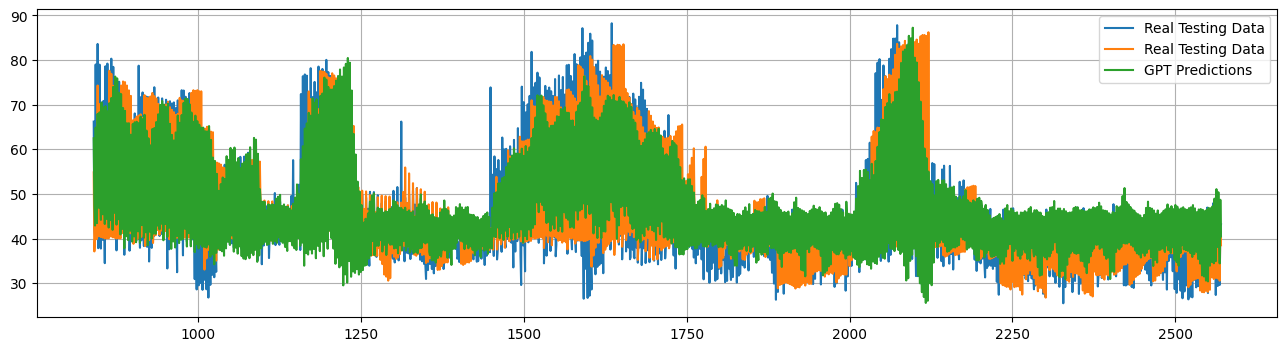

In [33]:
plt.figure(figsize=(16,4))
plt.plot(timefm_preds_filtered.index, timefm_preds_filtered['CPU usage [%]'], label='Real Testing Data')
plt.plot(timefm_preds_filtered.index, timefm_preds_filtered['timesfm'], label='Real Testing Data')
plt.plot(bilstm.index, bilstm['CPU Predictions'], label='GPT Predictions')
plt.grid()
plt.legend()
plt.show()

In [61]:
timefm_preds_filtered

,ds,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%],lstm,bi_lstm
840,2013-09-10 14:00:00,2,54.820068,48.381683,50.195778,51.907692,53.306057,54.820068,56.488472,58.316780,60.854839,65.070602,66.200000,63.186852,62.463398
841,2013-09-10 14:00:00,4,37.106361,33.805267,34.930965,35.725235,36.439075,37.106361,37.797363,38.466373,39.315739,40.538010,42.150000,46.762928,47.311848
842,2013-09-10 14:00:00,6,40.081627,37.210911,38.237358,38.890690,39.447903,40.081627,40.596943,41.301403,42.060482,43.186081,40.288889,39.453995,42.908863
843,2013-09-10 14:05:00,2,54.577301,47.803314,49.716557,51.461056,53.001324,54.577301,56.301453,58.196949,60.755543,65.185493,79.000000,64.630981,64.844467
844,2013-09-10 14:05:00,4,39.872742,36.415607,37.610111,38.457069,39.156979,39.872742,40.583977,41.320992,42.153774,43.367283,47.083333,46.732506,48.972000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,2013-09-12 13:55:00,4,41.433643,38.407131,39.449951,40.160408,40.797726,41.433643,41.997421,42.606697,43.336441,44.485180,38.808067,41.741810,50.373295
2567,2013-09-12 13:55:00,6,38.857761,33.099453,35.109219,36.553787,37.720234,38.857761,40.066826,41.178276,42.634708,44.741302,45.257607,42.022354,40.586586
2568,2013-09-12 14:00:00,2,30.552784,25.447556,27.180956,28.578602,29.639261,30.552784,31.673363,33.102859,34.616684,37.036915,29.581848,38.106579,34.425140
2569,2013-09-12 14:00:00,4,41.413181,38.385841,39.457668,40.153740,40.827709,41.413181,42.004337,42.653751,43.424789,44.512066,42.603264,40.667324,48.679150


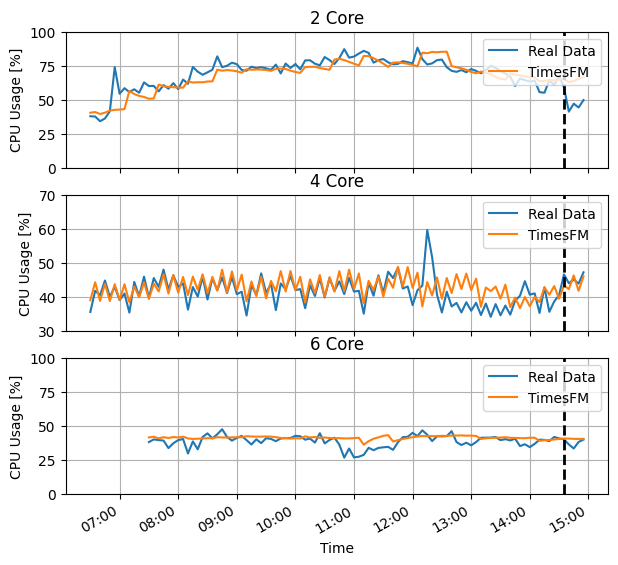

In [89]:
date = pd.to_datetime('2013-09-11 14:35:00')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(7,6), sharex=True)

ax1.plot(df2.index[198:300], df2['CPU usage [%]'][198:300], label='Real Data')
ax1.plot(df2.index[198:300], df2['timesfm-q-0.6'][198:300], label='TimesFM')
#ax1.plot(df2.index, df2['bi_lstm'], label='Bi-LSTM')
#ax1.plot(df2.index, df2['lstm'], label='LSTM')
#ax1.set_xlabel('Time')
ax1.set_ylabel('CPU Usage [%]')
ax1.set_ylim([0,100])
ax1.grid()
ax1.set_title('2 Core')
ax1.legend(loc='upper right')
ax1.axvline(date, color='black', linestyle='--', linewidth=2)

ax2.plot(df4.index[198:300], df4['CPU usage [%]'][198:300], label='Real Data')
ax2.plot(df4.index[198:300], df4['timesfm-q-0.7'][198:300], label='TimesFM')
#ax2.plot(df4.index[210:300], df4['bi_lstm'][210:300], label='Bi-LSTM')
#ax2.plot(df4.index[210:300], df4['lstm'][210:300], label='LSTM')

#ax2.set_xlabel('Time')
ax2.set_ylabel('CPU Usage [%]')
ax2.grid()
ax2.set_ylim([30,70])
ax2.set_title('4 Core')
ax2.legend(loc='upper right')
ax2.axvline(date, color='black', linestyle='--', linewidth=2)

ax3.plot(df6.index[210:300], df6['CPU usage [%]'][210:300], label='Real Data')
ax3.plot(df6.index[210:300], df6['timesfm-q-0.7'][210:300], label='TimesFM')
#ax3.plot(df6.index[210:300], df6['bi_lstm'][210:300], label='Bi-LSTM')
#ax3.plot(df6.index[210:300], df6['lstm'][210:300], label='LSTM')

ax3.set_xlabel('Time')
ax3.set_ylabel('CPU Usage [%]')
ax3.axvline(date, color='black', linestyle='--', linewidth=2)
ax3.grid()
ax3.set_ylim([0,100])
ax3.set_title('6 Core')
ax3.legend(loc='upper right')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.setp(ax3.get_xticklabels(), rotation=30, ha='right')
plt.savefig('models_bi_lstm_times.pdf', format='pdf')
plt.show()

In [90]:
df2[198:301]

,unique_id,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,CPU usage [%],lstm,bi_lstm
ds,,,,,,,,,,,,,,
2013-09-11 06:30:00,2,39.420368,35.053787,36.325020,37.573685,38.484859,39.420368,40.351887,41.438377,42.922718,45.525520,37.766667,37.886028,35.801777
2013-09-11 06:35:00,2,39.814804,35.182606,36.489357,37.692574,38.716991,39.814804,40.834064,42.077248,43.669819,46.598927,37.533333,38.517796,39.049686
2013-09-11 06:40:00,2,38.248848,33.738235,35.257004,36.516865,37.531002,38.248848,39.395081,40.736851,42.158897,44.780197,34.066667,38.448746,40.534740
2013-09-11 06:45:00,2,39.304489,33.632797,35.603252,36.878513,37.961811,39.304489,40.376114,41.773716,43.599983,46.574760,36.133333,37.614956,40.336273
2013-09-11 06:50:00,2,40.417130,34.416862,36.541458,37.899303,38.977097,40.417130,41.897045,43.405685,45.648525,48.759716,41.400000,37.616280,39.950539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-11 14:40:00,2,61.760639,56.220142,58.658775,59.886906,60.886177,61.760639,62.738659,63.588066,64.712234,66.780922,41.130199,62.854317,61.880165
2013-09-11 14:45:00,2,62.875050,55.855080,58.979031,60.415493,61.961033,62.875050,63.738541,64.985809,66.418503,68.939323,47.011131,56.227467,61.380970
2013-09-11 14:50:00,2,64.031891,55.865612,59.276058,61.382301,62.773003,64.031891,65.244110,66.525406,67.818024,70.586037,44.178123,53.938122,60.883331


In [19]:
def rmse(df):

    squared_diff = np.square(np.array(df['CPU usage [%]']) - np.array(df['timesfm']))

    # Calculate mean squared difference
    mse = np.mean(squared_diff)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return rmse

print(f"Root Mean Squared Error (RMSE): {rmse(timefm_preds)}")

Root Mean Squared Error (RMSE): 4.983595565098704


In [20]:
def calculate_mae(df):
    mae = mean_absolute_error(df['CPU usage [%]'], df['timesfm'])
    return mae

print(f"Root Mean Squared Error (RMSE): {calculate_mae(timefm_preds)}")

Root Mean Squared Error (RMSE): 3.1740121734255435


In [21]:
summ_inf = sum(inf_time)
summ_inf

236.09937596321106

In [22]:
len(inf_time)

336

In [23]:
summ_inf

236.09937596321106

In [24]:
(summ_inf/len(inf_time))*1000

702.6767141762233

In [ ]:
inf_timesfm = []
for i in range(1000):
    b_time = time.time()
    instance = X_test[i]
    instance_reshape = instance.reshape(1, instance.shape[0], instance.shape[1])
    bimodel_load.predict(instance_reshape)
    single_inftime = time.time() - b_time
    inf_time_bi.append(single_inftime) 
mili_inf_bi = [x * 1000 for x in inf_time_bi]
inf_time_bi[0]
mili_inf_bi = [x * 1000 for x in inf_time_bi]
mean_infer_bi = sum(mili_inf_bi) / len(mili_inf_bi)
mean_infer_bi

In [60]:
df_pred = pd.read_csv('/home/babarali/Extended_ProKube/datasets/bitbrains/times_prediction.csv')
df_pred = df_pred[['ds', 'unique_id', 'timesfm', 'timesfm-q-0.6', 'CPU usage [%]']]
##[1434:1743]
df_pred = df_pred.iloc[1554:1689]


In [56]:
df_pred = pd.read_csv('/home/babarali/Extended_ProKube/datasets/bitbrains/times_prediction.csv')
df_pred = df_pred[['ds', 'unique_id', 'timesfm', 'timesfm-q-0.6', 'CPU usage [%]']]
##[1434:1743]
df_pred = df_pred.iloc[1554:1683]

In [63]:
df_pred2 = df_pred[df_pred['unique_id']==2]

In [64]:
df_pred2 = df_pred[df_pred['unique_id']==2]

In [65]:
df_pred2.shape

(45, 5)

In [66]:
df_pred2.shape

(45, 5)

In [67]:
df_pred

,ds,unique_id,timesfm,timesfm-q-0.6,CPU usage [%]
1554,2013-09-11 09:50:00,2,70.743904,72.513824,76.533333
1555,2013-09-11 09:50:00,4,40.546910,41.035000,42.166667
1556,2013-09-11 09:50:00,6,39.639330,40.292896,40.855556
1557,2013-09-11 09:55:00,2,69.392440,71.324180,73.266667
1558,2013-09-11 09:55:00,4,46.444897,46.907673,46.133333
...,...,...,...,...,...
1684,2013-09-11 13:25:00,4,40.901405,41.838700,37.800000
1685,2013-09-11 13:25:00,6,39.894190,40.570847,41.711111
1686,2013-09-11 13:30:00,2,63.607887,65.389200,70.966667
1687,2013-09-11 13:30:00,4,37.140327,38.256443,34.500000
